In [283]:
import numpy as np
import matplotlib.pyplot as plt

In [284]:
def metropolis_algorithm(N,D,beta,b,random_seed:int, config_n, initial_config_type):
    assert initial_config_type == "hot" or initial_config_type == "cold", f"initial_config_type must be either 'hot' or 'cold'"
    np.random.seed(random_seed)
    random_number = np.random.rand()
    
    if initial_config_type == "cold":
        config = np.ones((N,)*D)
    elif initial_config_type == "hot":
        config =  np.random.choice([-1, 1], size=(N,)*D, p=[0.5, 0.5])
    ix = list(np.ndindex((N,)*D))


    magnetization_array = np.zeros((config_n,))
    energy_array = np.zeros((config_n,))

    def checkerboard_mask(shape):
        return np.indices(shape).sum(axis=0) % 2 == 0
    white_mask = checkerboard_mask((N,)*D)
    black_mask = np.logical_not(white_mask)
    

    # iterate over number of configurations (0.55seconds/1000 iters)
    for config_iter in range(config_n):
        # print(f"{config_iter}/{config_n}", end='\r')
        # print(config)


        #checkerboard array approach

        # random number array
        random_numbers = np.random.rand(N**D)
        random_array = random_numbers.reshape((N,)*D)

        # white
        neighbours = np.zeros((N,)*D)
        for i in range(D):
            neighbours = neighbours + (np.roll(config,1, axis=i)+np.roll(config,-1, axis=i))

        dH_array_white = np.exp(-(2*beta*config*neighbours +2*b*config))
        #only look at white indexes
        dH_array_white[black_mask] = 0
        white_flip_mask = dH_array_white > random_array
        # now flip accordingly based off of white spins
        config[white_flip_mask]*=-1
        # print(config)
        # now repeat for black
        neighbours = np.zeros((N,)*D)
        for i in range(D):
            neighbours = neighbours + (np.roll(config,1, axis=i)+np.roll(config,-1, axis=i))

        dH_array_black = np.exp(-(2*beta*config*neighbours +2*b*config))
        #only look at even indexes
        dH_array_black[white_mask] = 0
        black_flip_mask = dH_array_black > random_array
        
        config[black_flip_mask]*=-1

        # print(config)

        



        # # iterate over array points individually (57seconds/1000 iters)
        # for index in ix:
        #     # print(index)
        #     spin = config[index]
        #     random_number = np.random.rand()
        #     neighbours = 0
        #     # print("index", index)
        #     for i in range(D):
        #         if index[i] == 0:
        #             left = 0
        #         else:
        #             index_array = list(index)
        #             index_array[i] -=1
        #             left = config[tuple(index_array)]
        #         if index[i] == N-1:
        #             right = 0
        #         else:
        #             index_array = list(index)
        #             index_array[i] +=1
        #             right = config[tuple(index_array)]
        #         # print("left", left)
        #         # print("right", right)
        #         neighbours += left+ right
        #     dH = 2*beta*spin*neighbours    +2*b*spin
        #     # dH_history.append(dH)
        #     # print(np.exp(-dH))
        #     if np.exp(-dH)> random_number:
                
        #         config[index] = -spin
        #         flip_counter +=1
        #         # print("flipped", flip_counter, end='\r')
        
        magnetization_array[config_iter] = np.sum(config)

        #calculate config energy
        neighbours = np.zeros((N,)*D)
        for i in range(D):
            #only add right neighbours
            neighbours = neighbours + np.roll(config,1, axis=i)
        energy_config = np.sum(-beta*config*neighbours -b*config)
        energy_array[config_iter] = energy_config

    return magnetization_array, energy_array





    
        



In [285]:
import timeit
timeit.timeit(lambda: metropolis_algorithm(100,2,0.43,0.01,42,1000,'hot'), number = 1)

0.7080419999547303

In [383]:
magnetization_history, energy_history = metropolis_algorithm(100,2,0.43,0.01, 42,1000,"hot")



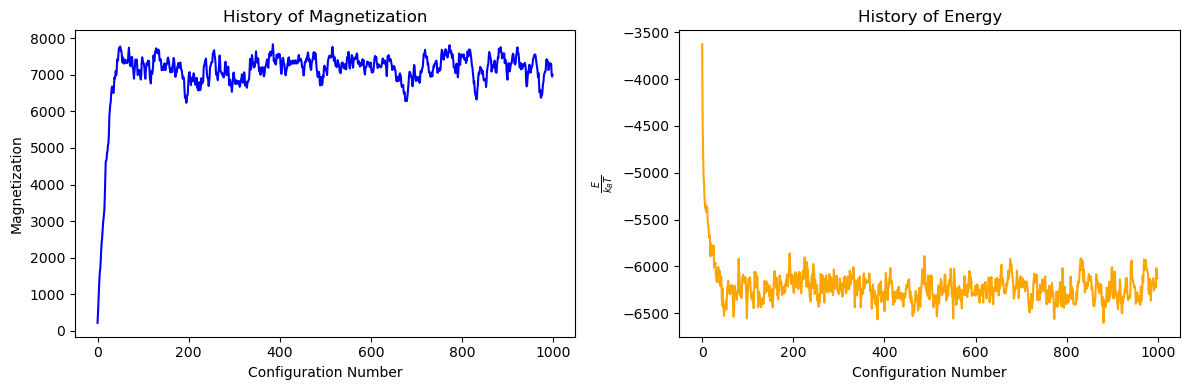

In [384]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
# Plot Magnetization
axes[0].plot(magnetization_history, color='blue')
axes[0].set_xlabel('Configuration Number')
axes[0].set_ylabel('Magnetization')
axes[0].set_title('History of Magnetization')

# Plot Energy
axes[1].plot(energy_history, color='orange')
axes[1].set_xlabel('Configuration Number')
axes[1].set_ylabel(r'$\frac{E}{k_B T}$')
axes[1].set_title('History of Energy')

plt.tight_layout()
plt.show()

In [314]:
replica_count = 500
config_number = 1000
magnetization_replicas = []
energy_replicas = []
for i in range (replica_count):
    print(i, end='\r')
    magnetization_history, energy_history = metropolis_algorithm(100,2,0.43,0.01, i,config_number,"hot")
    magnetization_replicas.append(magnetization_history)
    energy_replicas.append(energy_history)

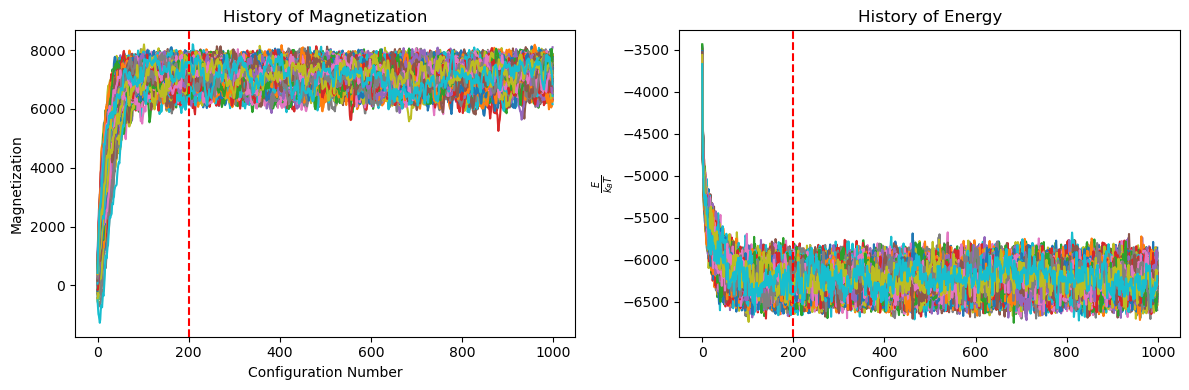

In [356]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
# Plot Magnetization
for magnetization_history in magnetization_replicas:
    axes[0].plot(magnetization_history)
    axes[0].set_xlabel('Configuration Number')
    axes[0].set_ylabel('Magnetization')
    axes[0].set_title('History of Magnetization')

# Plot Energy
for energy_history in energy_replicas:
    axes[1].plot(energy_history)
    axes[1].set_xlabel('Configuration Number')
    axes[1].set_ylabel(r'$\frac{E}{k_B T}$')
    axes[1].set_title('History of Energy')

axes[0].axvline(x=200, color='red', linestyle='--', label='Position 200')
axes[1].axvline(x=200, color='red', linestyle='--', label='Position 200')
plt.tight_layout()
plt.show()

In [351]:
Thermalization_start = 200
magnetization_replicas_array = np.array(magnetization_replicas)
energy_replicas_cropped = np.array(energy_replicas)[:,Thermalization_start:]
magnetization_replicas_cropped = magnetization_replicas_array[:,Thermalization_start:]


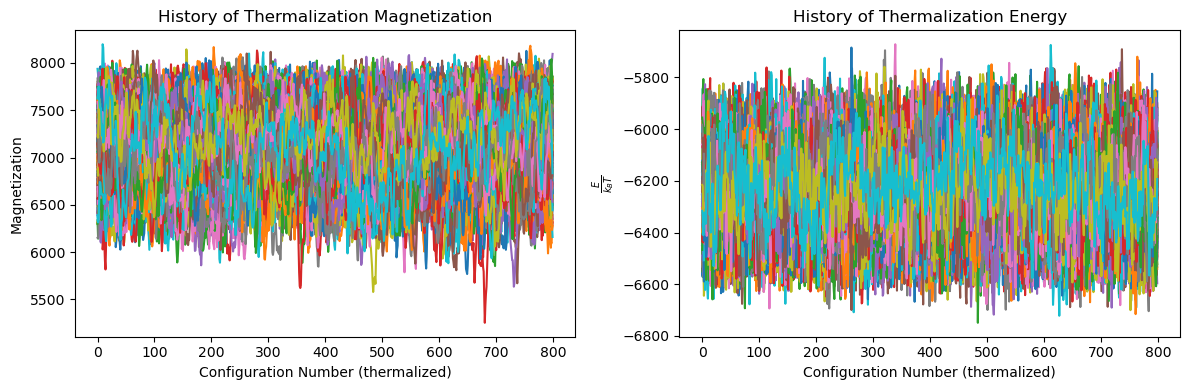

In [352]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
# Plot Magnetization
for i in range(magnetization_replicas_cropped.shape[0]):
    axes[0].plot(magnetization_replicas_cropped[i,:])
axes[0].set_xlabel('Configuration Number (thermalized)')
axes[0].set_ylabel('Magnetization')
axes[0].set_title('History of Thermalization Magnetization')

# Plot Energy
for i in range(energy_replicas_cropped.shape[0]):
    axes[1].plot(energy_replicas_cropped[i,:])
axes[1].set_xlabel('Configuration Number (thermalized)')
axes[1].set_ylabel(r'$\frac{E}{k_B T}$')
axes[1].set_title('History of Thermalization Energy')

plt.tight_layout()
plt.show()

In [353]:
# expectation value of Magnetization
replica_magn_means = 0
replica_enrg_means = 0
for i in range(replica_count):
    replica_magn_means += np.mean(magnetization_replicas_cropped[i,:])    
    replica_enrg_means += np.mean(energy_replicas_cropped[i,:])


expc_magnetization = 1/replica_count*replica_magn_means
expc_energy = 1/replica_count*replica_enrg_means
magn_stdev = 0
enrg_stdev = 0
for i in range(replica_count):
    magn_stdev += (np.mean(magnetization_replicas_cropped[i,:]) - expc_magnetization)**2
    enrg_stdev += (np.mean(energy_replicas_cropped[i,:]) - expc_energy)**2 

error_magnetization = (1/(replica_count*(replica_count-1))* magn_stdev)**(0.5)
error_energy = (1/(replica_count*(replica_count-1))* enrg_stdev)**(0.5)

In [354]:
print(f"The expectation value of <M> is {expc_magnetization:.5e} ± {error_magnetization:.5e}")
print(f"The expectation value of <M> is {expc_energy:.5e} ± {error_energy:.5e}")

The expectation value of <M> is 7.18404e+03 ± 2.21933e+00
The expectation value of <M> is -6.23655e+03 ± 6.52624e-01


Plot probability distribution

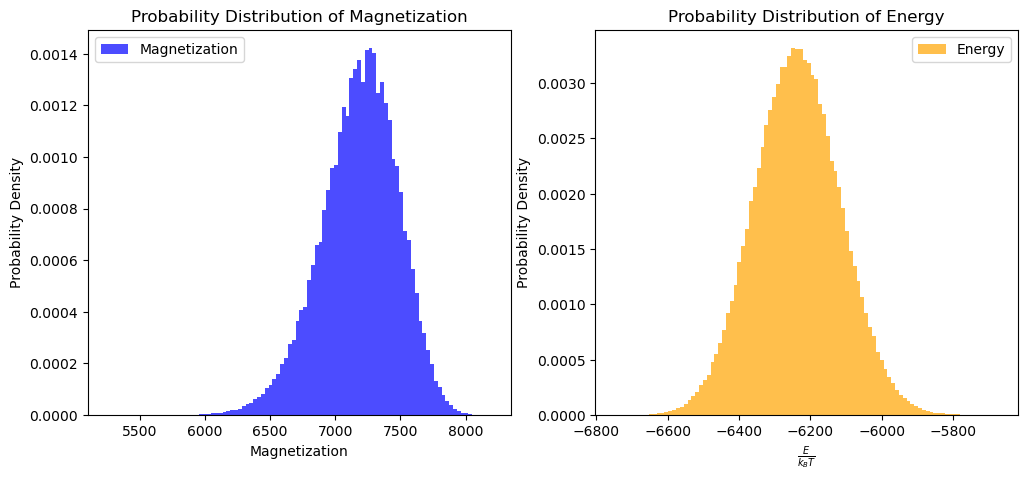

In [355]:
magnetization_data = magnetization_replicas_cropped.reshape(replica_count * (config_number-Thermalization_start))
energy_data = energy_replicas_cropped.reshape(replica_count * (config_number-Thermalization_start))

# Create subplots
plt.figure(figsize=(12, 5))

# Plot the first histogram
plt.subplot(1, 2, 1)
plt.hist(magnetization_data, bins=100, density=True, alpha=0.7, color='blue', label='Magnetization')
plt.xlabel('Magnetization')
plt.ylabel('Probability Density')
plt.title('Probability Distribution of Magnetization')
plt.legend()

# Plot the second histogram
plt.subplot(1, 2, 2)
plt.hist(energy_data, bins=100, density=True, alpha=0.7, color='orange', label='Energy')
plt.xlabel(r'$\frac{E}{k_B T}$')
plt.ylabel('Probability Density')
plt.title('Probability Distribution of Energy')
plt.legend()

## Statistical error behaviour

### Increasing number of configurations

In [388]:
replica_count = 10
config_number_list = list(range(300, 1501, 100))
errors_array = np.zeros((2,len(config_number_list)))
for j,config_number in enumerate(config_number_list):
    magnetization_replicas = []
    energy_replicas = []
    for i in range (replica_count):
        print(f'{i}/{replica_count}', end='\r')
        magnetization_history, energy_history = metropolis_algorithm(20,2,0.43,0.01, i,config_number,"hot")
        magnetization_replicas.append(magnetization_history)
        energy_replicas.append(energy_history)


    Thermalization_start = 25
    magnetization_replicas_array = np.array(magnetization_replicas)
    energy_replicas_cropped = np.array(energy_replicas)[:,Thermalization_start:]
    magnetization_replicas_cropped = magnetization_replicas_array[:,Thermalization_start:]



    replica_magn_means = 0
    replica_enrg_means = 0
    for i in range(replica_count):
        replica_magn_means += np.mean(magnetization_replicas_cropped[i,:])    
        replica_enrg_means += np.mean(energy_replicas_cropped[i,:])


    expc_magnetization = 1/replica_count*replica_magn_means
    expc_energy = 1/replica_count*replica_enrg_means
    magn_stdev = 0
    enrg_stdev = 0
    for i in range(replica_count):
        magn_stdev += (np.mean(magnetization_replicas_cropped[i,:]) - expc_magnetization)**2
        enrg_stdev += (np.mean(energy_replicas_cropped[i,:]) - expc_energy)**2 

    error_magnetization = (1/(replica_count*(replica_count-1))* magn_stdev)**(0.5)
    error_energy = (1/(replica_count*(replica_count-1))* enrg_stdev)**(0.5)

    errors_array[0,j] = error_magnetization
    errors_array[1,j] = error_energy


Text(0.5, 1.0, 'H Energy tatistical error vs number of configurations')

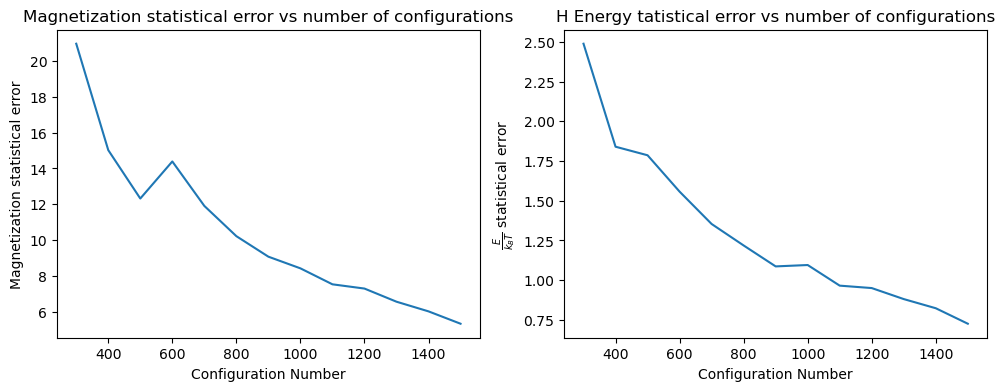

In [389]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].plot(config_number_list, errors_array[0,:])
axes[1].plot(config_number_list, errors_array[1,:])
axes[0].set_xlabel('Configuration Number')
axes[0].set_ylabel('Magnetization statistical error')
axes[0].set_title('Magnetization statistical error vs number of configurations')

axes[1].set_xlabel('Configuration Number')
axes[1].set_ylabel(r'$\frac{E}{k_B T}$ statistical error')
axes[1].set_title('Energy tatistical error vs number of configurations')

### Increase in number of replicas

In [385]:
config_number = 250
replica_count_list = list(range(10, 101, 10))
print(replica_count_list)
errors_array = np.zeros((2,len(replica_count_list)))
for j,replica_count in enumerate(replica_count_list):
    magnetization_replicas = []
    energy_replicas = []
    for i in range (replica_count):
        print(f'{i}/{replica_count}', end='\r')
        magnetization_history, energy_history = metropolis_algorithm(20,2,0.43,0.01, i,config_number,"hot")
        magnetization_replicas.append(magnetization_history)
        energy_replicas.append(energy_history)


    Thermalization_start = 25
    magnetization_replicas_array = np.array(magnetization_replicas)
    energy_replicas_cropped = np.array(energy_replicas)[:,Thermalization_start:]
    magnetization_replicas_cropped = magnetization_replicas_array[:,Thermalization_start:]



    replica_magn_means = 0
    replica_enrg_means = 0
    for i in range(replica_count):
        replica_magn_means += np.mean(magnetization_replicas_cropped[i,:])    
        replica_enrg_means += np.mean(energy_replicas_cropped[i,:])


    expc_magnetization = 1/replica_count*replica_magn_means
    expc_energy = 1/replica_count*replica_enrg_means
    magn_stdev = 0
    enrg_stdev = 0
    for i in range(replica_count):
        magn_stdev += (np.mean(magnetization_replicas_cropped[i,:]) - expc_magnetization)**2
        enrg_stdev += (np.mean(energy_replicas_cropped[i,:]) - expc_energy)**2 

    error_magnetization = (1/(replica_count*(replica_count-1))* magn_stdev)**(0.5)
    error_energy = (1/(replica_count*(replica_count-1))* enrg_stdev)**(0.5)

    errors_array[0,j] = error_magnetization
    errors_array[1,j] = error_energy

[10, 20, 30, 40, 50, 60, 70, 80, 90, 100]


Text(0.5, 1.0, 'H Energy tatistical error vs number of replicas')

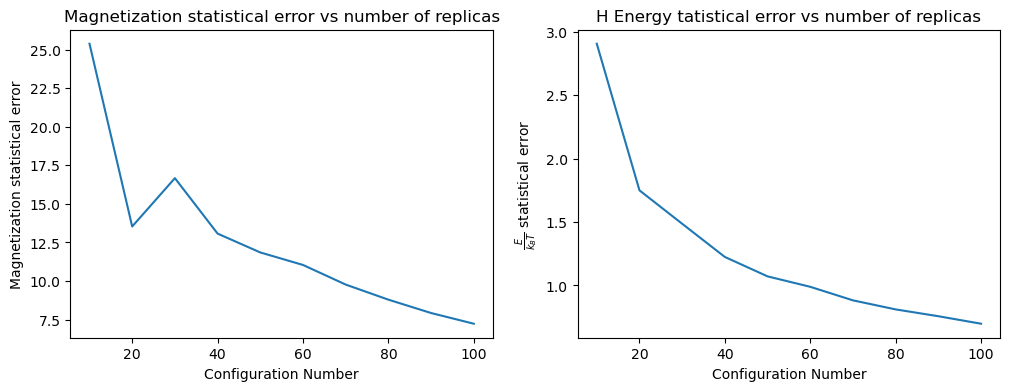

In [386]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].plot(replica_count_list, errors_array[0,:])
axes[1].plot(replica_count_list, errors_array[1,:])
axes[0].set_xlabel('Configuration Number')
axes[0].set_ylabel('Magnetization statistical error')
axes[0].set_title('Magnetization statistical error vs number of replicas')

axes[1].set_xlabel('Configuration Number')
axes[1].set_ylabel(r'$\frac{E}{k_B T}$ statistical error')
axes[1].set_title('Energy statistical error vs number of replicas')